In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   

# Printing config:
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.expand_frame_repr', False) # for printing full objects
np.random.seed(42)


#### Main Parameters ####
dataFilePath = "./data.csv"
labelColName = 'target'
actPlotsFlag = True


# Load the data
data_df = pd.read_csv(dataFilePath)

In [2]:
def colNameListByDType(df, numericCols=True):
    # # # # # # # # # #
    # Finds the names of numeric/non-numeric columns of a dataframe
    # Args:
    #       df - (pandas dataframe)
    #       numericCols - (bool), True - for numerical columns, False - for non-numerical columns
    # Return:
    #       col_name_list - (list of strings), the matched columns name
    # # # # # # # # # #
    from pandas.api.types import is_numeric_dtype

    col_name_list = list()
    for col in df.columns:
        if(numericCols): # if the numeric columns are required
            if(is_numeric_dtype(df[col]) == True):
                col_name_list += [col]
        else:   # the non-numeric columns are required
            if (is_numeric_dtype(df[col]) == False):
                col_name_list += [col]

    # apply doesn't work with is_numeric_dtype for some reason!
    #if(numericCols):
    #    col_name_list = df.columns[df.apply(lambda x: is_numeric_dtype(x))]
    #else:
    #    col_name_list = df.columns[~np.array(df.apply(is_numeric_dtype))]

    return col_name_list


Data head :
   target       path                                      user_agent country   fuel  source_port    city county  contacts_n  latitude  longitude  bandwidth  respose timezone  download_time  port  time_total
0       1  /rss/news  FeedNotifier/2.6 +http://www.feednotifier.com/      GB 5.8229        52260  LONDON    NaN           7   51.5000    -0.1200       5000       35      GMT             73    -1     57.6208
1       1  /rss/news  FeedNotifier/2.6 +http://www.feednotifier.com/      GB 4.6307        51355  LONDON    NaN           3   51.5000    -0.1200       5000       31      GMT             87    -1     53.9166
2       1  /rss/news  FeedNotifier/2.6 +http://www.feednotifier.com/      GB 4.4599        58974  LONDON    NaN           6   51.5000    -0.1200       5000       43      GMT             82    -1     56.4803
3       1  /rss/news  FeedNotifier/2.6 +http://www.feednotifier.com/      GB 3.5263        58309  LONDON    NaN           5   51.5000    -0.1200       5000    

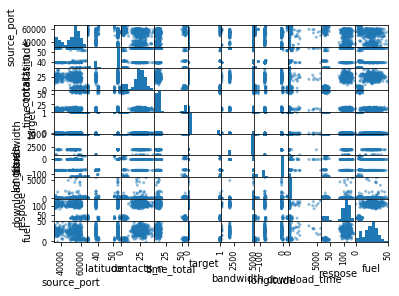

In [3]:
#### DADA ANALYSIS ####

import random
from pandas.plotting import scatter_matrix
from scipy.stats import normaltest

print("\nData head :\n" + str(data_df.head()))
print("\nData shape : " + str(data_df.shape))  # (145818, 17)

# Checking cols data type and existence of missing values 
# by comparing the # of values in a col to the df # of rows.
print(("\nData info: \n%s") % data_df.info())  
""" country = US :      47616
    non-missing county: 47616
    Meaning - there are no actual missing values under 'county' """

# Basic statistics:
print(("\npct of target (label) = 1: %.4f") % (100 * np.sum(data_df[labelColName]) / data_df.shape[0]))
print(("\nSummary of numeric features: \n%s") % data_df.describe(include=[np.number]))  
print(("\nSummary of non-numeric features: \n%s") %data_df.describe(include=['O'])) 

non_numeric_cols = list(set(['path']).symmetric_difference(colNameListByDType(data_df, numericCols=False)))

for col in non_numeric_cols:
    print(("\nUnique value (normed) count of column : %s\n%s") % (col, data_df[col].value_counts(normalize=True)))

# Check if the numeric columns in the dataset are coming from normal dist
# (will help us decide how to scale the features later on):
numeric_cols = colNameListByDType(data_df, numericCols=True)
alpha = 1e-3
for i in numeric_cols:
    k2, p = normaltest(data_df[i])  # null hypothesis: the feature comes from a normal distribution
    if (p < alpha):  # The null hypothesis can be rejected
        print("It is most likely that %s is not coming from a normal distribution, pval = %.4f" % (i, p))
    else:  # The null hypothesis cannot be rejected
        print("We cannot reject the hypothesis that %s is coming from a normal distribution, pval = %.4f" % (i, p))

if(actPlotsFlag):
    # Scatter plot of numeric features:
    numeric_cols = list(set(['port']).symmetric_difference(numeric_cols)) # 'port' has zero variance, ignore it in scatter plot
    sample_idx = random.sample(range(0, data_df.shape[0] - 1), 500)
    scatter_matrix(data_df.loc[sample_idx, numeric_cols])
    """ It seems like 'total_ime' has the greatest separation with respect to 'target'. """

In [4]:
#### HELPER FUNCTIONS ####

def colNamesToFilter(df, method, min_val):
    # # # # # # # # # #
    # Finds out which columns should be filtered (according to the specified method and min_val).
    # Args:
    #       df - (pandas dataframe), the dataset
    #       method - (string), possible values: 'freq' - frequency
    #                                           'std' - standard deviation
    #       min_val - (float), columns with method value lower or equal to this argument will be filtered
    # Return:
    #       f_cols - (list of strings), list of column names to filter
    # # # # # # # # # #
    
    f_cols = []
    if(method == 'freq'):
        cols_method = df.astype(bool).sum(axis=0)
    elif(method == 'std'):
        cols_method = df.std(axis=0)
    else:
        print("colNamesToFilter warning: method is empty, no filter will be applied.")
    f_cols += list(cols_method[cols_method <= min_val].index)
    return f_cols

def extractFeaturesFromPath(path_sr):
    # # # # # # # # # #
    # Extract new features from the elements constructing a 'path' (column)
    # Args:
    #       path_sr - (pandas series), the 'path' column (a column of strings with '/' delimiter)
    # Return:
    #       w_freq_df - (pandas dataframe), the new extracted features - word frequencies (original indices for future merge)
    # # # # # # # # # #
    from sklearn.feature_extraction.text import CountVectorizer

    delimiter = "/"
    # Add 'empty_end' string to paths that end with "/", most likely represent a directory:
    end_dlt_idx = path_sr.str.endswith(delimiter)
    path_sr.loc[end_dlt_idx] = path_sr.loc[end_dlt_idx].apply(lambda x: x + "empty_end")
    path_sr = path_sr.apply(lambda x: x.replace(delimiter, " "))
    cv = CountVectorizer()
    cv.fit(path_sr)
    print("DEBUG: extractFeaturesFromPath - number of words: %d" % len(cv.vocabulary_))
    w_freq_csr = cv.transform(path_sr)
    cols_name = ["path_" + i for i in cv.get_feature_names()]
    w_freq_df = pd.DataFrame(w_freq_csr.todense(), columns=cols_name)
    remove_cols = colNamesToFilter(w_freq_df, method='freq', min_val=10)
    w_freq_df.drop(columns=remove_cols, inplace=True)  # dropping rare features (less than 10 occurrences)
    print("extractFeaturesFromPath - Adding %d features extracted from 'path'." % w_freq_df.shape[1])
    return w_freq_df

def featureDistPlot(df):
    # # # # # # # # # #
    # Plot the pdf of the features in a dataset
    # Args:
    #       df - (pandas dataframe), the dataset, where the columns represent the features
    # Return:
    #       Nothing
    # # # # # # # # # #
    import seaborn as sns
    
    f, axes = plt.subplots(1, df.shape[1], figsize=(20, 3), sharex=True)
    for i in range(0, df.shape[1]):
        #df[df.columns[i]].plot.kde(ax=axes[i])
        sns.distplot(df[df.columns[i]], ax=axes[i]) #hist=True, norm_hist=True
    return

def featureScaling(data_df, fe_to_scale_list, plotDist=False):
    # # # # # # # # # #
    # Scale (MinMax) the specified columns of a dataset [0,1]
    # Note: we don't perform standardization because the continues features are not normally distributed.
    # Args:
    #       data_df - (pandas dataframe), the dataset, where the columns represent the features
    #       fe_to_scale_list - (list of strings), feature names to scale.
    #       plotDist - (bool), True for activating plot execution, False otherwise.
    # Return:
    #       s_data_df - (pandas dataframe), the scaled dataset
    # # # # # # # # # #
    from sklearn.preprocessing import MinMaxScaler

    s_data_df = data_df.copy(deep=True)
    min_max_scaler = MinMaxScaler()
    s_data_df[fe_to_scale_list] = min_max_scaler.fit_transform(s_data_df[fe_to_scale_list])
    
    # Plot the feature distribution to analyse if log-transform is required:
    #if(plotDist):
    #    # Plot the features (fe_to_scale_list) dist:
    #    featureDistPlot(s_data_df[fe_to_scale_list])
    #    """Log-transform won't help us in this case to approximate to normal distribution."""
    return s_data_df

In [5]:
#### DATA PREPROCESSING (*feature extraction, remove outliers, feature reduction and feature scaling) ####
# Note: no missing data handling is done, because there are no such cases in our dataset.

import re
from sklearn.neighbors import LocalOutlierFactor

# DOTO: REMOVE data loading & reset!!
# Load the data
#%reset
#data_df = pd.read_csv(dataFilePath)


# FEATURE EXTRACTION:
# Convert categorical features to dummy features:
categorical_cols = list(set(['path']).symmetric_difference(colNameListByDType(data_df, numericCols=False)))
print("DEBUG: categorical columns for dummy features extraction: %s" % categorical_cols)
ctg_dummies_df = pd.get_dummies(data=data_df[categorical_cols], drop_first=True)
print("DEBUG: ctg_dummies_df shape: " + str(ctg_dummies_df.shape))
pp_data_df = pd.concat([data_df.drop(columns=categorical_cols), ctg_dummies_df], axis=1)
print("DEBUG: pp_data_df shape after concatenating categorical dummies: " + str(pp_data_df.shape))

# Extract features (keywords) from 'path':
path_fe_df = extractFeaturesFromPath(pp_data_df['path'])
pp_data_df = pd.concat([pp_data_df, path_fe_df], axis=1)
pp_data_df.drop(columns='path', inplace=True)
print("DEBUG: pp_data_df shape after concatenating path features: " + str(pp_data_df.shape))

DEBUG: categorical columns for dummy features extraction: ['timezone', 'country', 'city', 'user_agent', 'county']
DEBUG: ctg_dummies_df shape: (145818, 47)
DEBUG: pp_data_df shape after concatenating categorical dummies: (145818, 59)


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


DEBUG: extractFeaturesFromPath - number of words: 2054
extractFeaturesFromPath - Adding 424 features extracted from 'path'.
DEBUG: pp_data_df shape after concatenating path features: (145818, 482)


In [6]:
#### DATA PREPROCESSING (feature extraction, *remove outliers, feature reduction and feature scaling) ####

# REMOVE OUTLIERS 
# Fit LOF
lof_clf = LocalOutlierFactor(n_neighbors=20, n_jobs=-1)
lof_pred = lof_clf.fit_predict(pp_data_df.drop(columns=labelColName))
print(("DEBUG: Before outliers cleaning - pct of class 1 samples = %.4f") % 
      (100*sum(pp_data_df[labelColName])/pp_data_df.shape[0]))
outlier_idx = np.where(lof_pred == -1)[0]
pp_data_df.drop(index=outlier_idx, inplace=True)
print(("DEBUG: After outliers cleaning - pct of class 1 samples = %.4f") % 
      (100*sum(pp_data_df[labelColName])/pp_data_df.shape[0]))
print(("%d outlier samples were deleted.") % len(outlier_idx))

DEBUG: Before outliers cleaning - pct of class 1 samples = 11.8593
DEBUG: After outliers cleaning - pct of class 1 samples = 11.1943
14582 outlier samples were deleted.


In [8]:
#### DATA PREPROCESSING (feature extraction, remove outliers, *feature reduction and feature scaling) ####

# FEATURE REDUCTION:
# TODO: try PCA instead - will take care of multicollinearity 
remove_cols = []
# Correlation analysis:
abs_corr_df = pp_data_df.corr().abs() # (absolute value) correlation matrix
# the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1):
ordered_abs_corr = (abs_corr_df.where(np.triu(np.ones(abs_corr_df.shape), k = 1).astype(np.bool)).stack().sort_values(ascending=False))

# Find redundant features:
corr_threshold = 0.9
corr_fe = ordered_abs_corr[ordered_abs_corr >= corr_threshold] # series object with 2 indices (2 features)
# print("DEBUG: abs(correlation) == 1 :\n%s" % corr_fe)
corr_fe_index_1 = corr_fe.index.get_level_values(0)
corr_fe_index_2 = corr_fe.index.get_level_values(1)
# Define the redundant features list:
if(any(re.search(labelColName, i) != None for i in corr_fe_index_1) == False): # If 'target' is not in corr_fe first index
    remove_cols += list(corr_fe_index_1)
elif(any(re.search(labelColName, i) != None for i in corr_fe_index_2) == False):  # If 'target' is not in corr_fe second index
    remove_cols += list(corr_fe_index_2)
else: # 'target' is in both indices - not supported for now.
    print(labelColName + "is in both corr_fe indices. This scenario is not yet supported - no high-correlation filter will be applied.")

# Zero std filter:
remove_cols += colNamesToFilter(pp_data_df, method='std', min_val=0.)
# Frequency filter:
remove_cols += colNamesToFilter(pp_data_df, method='freq', min_val=10.)
remove_cols = set(remove_cols) # Remove duplicates

print(("High correlation + std + freq filters: delete %d out of %d columns.") % 
      (len(remove_cols), pp_data_df.shape[1]))
pp_data_df.drop(columns=remove_cols, inplace=True)

# Multicollinearity filter (detected by existence of tiny eigenvalues of the correlation matrix)
""" 
Existence of tiny eigenvalues (very close to zero) and high sqrt(max_eigval/min_eigval) of the correlation matrix 
implies multicollinearity existence. The corresponding eigenvectors can detail the dependency of the features.
"""
corr_df = pp_data_df.drop(columns=[labelColName]).corr()
remove_cols = []
eigval, eigvec = np.linalg.eig(corr_df)
min_eigval = 0.001
small_eigval_idx = np.where(eigval <= min_eigval)[0]
for i in small_eigval_idx:
    #print("DEBUG: Eigenvector of eigenvalue %.15f :\n%s\n" % (eigval[i], eigvec[:, i]))
    # Keep only one of the major features and remove the rest
    remove_cols += list(corr_df.columns[np.where(np.abs(eigvec[:, i]) >= 0.01)[0]][:-1])
    #print("DEBUG: multicollinearity (major) relation: %s" % list(corr_df.columns[np.where(np.abs(eigvec[:, i]) >= 0.1)[0]]))

remove_cols = set(remove_cols) # Remove duplicates
print(("Multicollinearity filter: delete %d out of %d columns.") % (len(remove_cols), pp_data_df.shape[1]))
#print("DEBUG: remove_cols = %s" % remove_cols)
pp_data_df.drop(columns=remove_cols, inplace=True)
print("Preprocessed data shape after feature reduction - " + str(pp_data_df.shape))

High correlation + std + freq filters: delete 180 out of 482 columns.
Multicollinearity filter: delete 161 out of 302 columns.
Preprocessed data shape after feature reduction - (131236, 141)


In [9]:
#### DATA PREPROCESSING (feature extraction, remove outliers, feature reduction and *feature scaling) ####

# FEATURE SCALING:
fe_to_scale_list = pp_data_df.columns[np.array(pp_data_df.apply(lambda x: x.min() < 0)) |
                                      np.array(pp_data_df.apply(lambda x: x.max() > 1))]
pp_data_df = featureScaling(pp_data_df, fe_to_scale_list, plotDist=actPlotsFlag)

In [10]:
#### DEFINE CLASSIFIERS (Decision Tree, Random Forest, SVM) ####

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

dt = tree.DecisionTreeClassifier(max_depth=1)  # , min_samples_leaf=100)
rf = RandomForestClassifier(max_depth=3, random_state=0)  # , min_samples_leaf=100))
svm = SVC(kernel='linear')

clf_list = [dt, rf, svm]

In [12]:
#### EVALUATE CLASSIFIERS (precision, recall, f1) AND CHOOSE THE BEST ONE ####

from sklearn.model_selection import cross_validate, ShuffleSplit

X = pp_data_df.drop(columns=labelColName)
y = pp_data_df[labelColName]

# It is essential to set the seed (random_state) to be able to compare the classifiers performance
cv = ShuffleSplit(n_splits=5, test_size=0.4, random_state=0) 
scoring = ('precision', 'recall', 'f1')
f1_scores = []
for clf in clf_list:
    print(("\nEvaluate classifier: %s") % type(clf))
    scores = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    f1_scores.append(scores["test_f1"].mean())
    for s in scoring:
        print("(class 1) %s: %f" % (s, scores["test_" + s].mean()))
f1_scores = np.array(f1_scores)
best_clf = clf_list[np.where(f1_scores == max(f1_scores))[0][0]]
print(("\nWe recommend using the following classifier for predicting %s:\n%s") % (labelColName, best_clf))


Evaluate classifier: <class 'sklearn.tree.tree.DecisionTreeClassifier'>
(class 1) precision: 0.991536
(class 1) recall: 0.994399
(class 1) f1: 0.992965

Evaluate classifier: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
(class 1) precision: 1.000000
(class 1) recall: 0.043067
(class 1) f1: 0.082574

Evaluate classifier: <class 'sklearn.svm.classes.SVC'>
(class 1) precision: 0.998981
(class 1) recall: 0.999526
(class 1) f1: 0.999253

We recommend using the following classifier for predicting target:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [13]:
def plotTopFeatures(coef_nparr, fe_name_list, top_features=20):
    # # # # # # # # # #
    # Plots the k min and max coefficients
    # Args:
    #       coef_nparr - (numpy ndarray), the model's coefficients
    #       fe_name_list - (list of strings), the features names
    #       top_features - (int), k
    # Return:
    #       Nothing
    # # # # # # # # # #

    top_positive_coefficients = np.argsort(coef_nparr)[-top_features:]
    top_negative_coefficients = np.argsort(coef_nparr)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # Create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef_nparr[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef_nparr[top_coefficients], color=colors)
    feature_names = np.array(fe_name_list)
    plt.xticks(np.arange(0,  2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    return

End of script


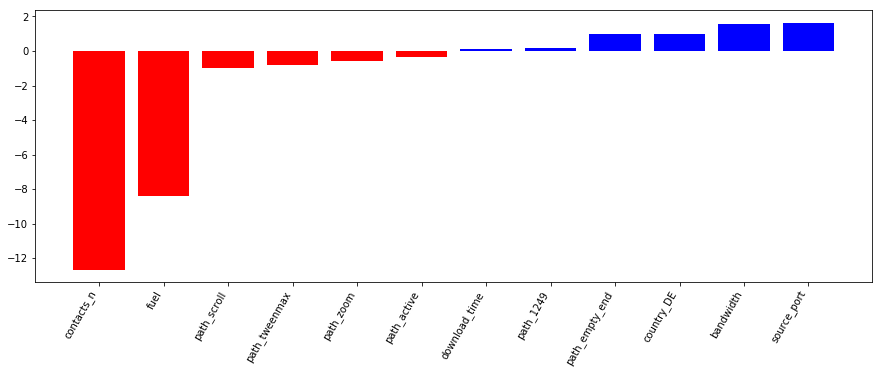

In [15]:
# Plot the most important features of the best classifier:
best_clf.fit(X, y)  # train the best classifier on the entire dataset
# SVM:
if (str(type(best_clf)) == "<class 'sklearn.svm.classes.SVC'>"):  
    coefs = best_clf.coef_.ravel()
# Decision Tree / Random Forest:
elif (str(type(clf)) in ["<class 'sklearn.ensemble.forest.RandomForestClassifier'>", 
                         "<class 'sklearn.tree.tree.DecisionTreeClassifier'>"]):
    coefs = clf.feature_importances_.ravel()
else:
    coefs = []
    print("Unrecognized model, we cannot plot the model's most important features.")
plotTopFeatures(coefs, X.columns, top_features=6)
print("End of script")
    
